In [1]:

# Library Imports
import os
import import_ipynb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, median, mode, stdev 

# from Descript import extract
%matplotlib inline


In [19]:

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [3]:

# Read CSV file contianing cross-sectional data
df = pd.read_csv("./finalDF.csv", sep=",", header=0)


In [4]:
# Find the unique client IDs contained in the dataset
df['CutitronicsClientID'].unique()
df['treatmentDate'] = pd.to_datetime(df['treatmentDate'], format='%Y-%m-%d')

In [5]:

# Create time-series data from cross-sectional data.
# i.e select only one client ID for each dataset.

client1 = df.loc[df['CutitronicsClientID'] == 'client1'].groupby(['treatmentDate']).agg({ 
    'CtrlSkinHealth': 'mean',
    'compliance': 'mean'})


client2 = df.loc[df['CutitronicsClientID'] == 'client2'].groupby(['treatmentDate']).agg({ 
    'CtrlSkinHealth': 'mean',
    'compliance': 'mean'})


client3 = df.loc[df['CutitronicsClientID'] == 'client3'].groupby(['treatmentDate']).agg({ 
    'CtrlSkinHealth': 'mean',
    'compliance': 'mean'})


client5 = df.loc[df['CutitronicsClientID'] == 'client5'].groupby(['treatmentDate']).agg({ 
    'CtrlSkinHealth': 'mean',
    'compliance': 'mean'})



In [77]:
def VARmod(dfName):
    
    global df_differenced
    
    fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = dfName[dfName.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(dfName.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();
    
    
    maxlag=10
    test = 'ssr_chi2test'
    def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
        """Check Granger Causality of all possible combinations of the Time series.
        The rows are the response variable, columns are predictors. The values in the table 
        are the P-Values. P-Values lesser than the significance level (0.05), implies 
        the Null Hypothesis that the coefficients of the corresponding past values is 
        zero, that is, the X does not cause Y can be rejected.
        data      : pandas dataframe containing the time series variables
        variables : list containing names of the time series variables.
        """
        
        dfName = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in dfName.columns:
            for r in dfName.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                dfName.loc[r, c] = min_p_value
        dfName.columns = [var + '_x' for var in variables]
        dfName.index = [var + '_y' for var in variables]
        print("Granger Causality Results \n\n", dfName)
        print("\n\n")  
        
    grangers_causation_matrix(dfName, variables = dfName.columns)
    
    # Create function for cointegration test
    def cointegration_test(dfName, alpha=0.05): 
        """Perform Johanson's Cointegration Test and Report Summary"""
        out = coint_johansen(dfName,-1,5)
        d = {'0.90':0, '0.95':1, '0.99':2}
        traces = out.lr1
        cvts = out.cvt[:, d[str(1-alpha)]]
        def adjust(val, length= 6): return str(val).ljust(length)

        # Summary
        print("Cointegration Test \n\n" + 'Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
        for col, trace, cvt in zip(dfName.columns, traces, cvts):
            print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

    cointegration_test(dfName)
    global nobs
    nobs = 10
    dfName_train, dfName_test = dfName[0:-nobs], dfName[-nobs:]

    # Check size
    print("\n\n", dfName_train.shape)
    print(dfName_test.shape, "\n\n")
    
    
    def adfuller_test(series, signif=0.05, name='', verbose=False):
        """Perform ADFuller to test for Stationarity of given series and print report"""
        r = adfuller(series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue'] 
        def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
        print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["test_statistic"]}')
        print(f' No. Lags Chosen       = {output["n_lags"]}')

        for key,val in r[4].items():
            print(f' Critical value {adjust(key)} = {round(val, 3)}')

        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")
            
    # ADF Test on each column
    for name, column in dfName_train.iteritems():
        adfuller_test(column, name=column.name)
        print('\n')
       
    # First Difference
    df_differenced = dfName_train.diff().dropna()
    # ADF Test on each column of 1st Differences Dataframe
    for name, column in df_differenced.iteritems():
        adfuller_test(column, name=column.name)
        print('\n')

    # # Second Difference
    # df_differenced = df_differenced.diff().dropna()
    # # ADF Test on each column of 1st Differences Dataframe
    # for name, column in df_differenced.iteritems():
    #     adfuller_test(column, name=column.name)
    #     print('\n')
    
    model = VAR(df_differenced)
    for i in [1,2,3,4,5,6,7,8,9]:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')

    x = model.select_order(maxlags=12)
    print(x.summary())

    model_fitted = model.fit(6)
    print(model_fitted.summary())
    
    # Get the lag order
    lag_order = model_fitted.k_ar
    print(lag_order)  #> 4

    # Input data for forecasting
    forecast_input = df_differenced.values[-lag_order:]
    print("forecast Input", forecast_input)
    
    
    # Forecast
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=dfName.index[-nobs:], columns=dfName.columns + '_2d')
    df_forecast = df_forecast.astype('int32')
    print(df_forecast.head(15))

    def invert_transformation(df_train, df_forecast, second_diff=False):
        """Revert back the differencing to get the forecast to original scale."""
        df_fc = df_forecast.copy()
        columns = dfName_train.columns
        for col in columns:        
            # Roll back 2nd Diff
            if second_diff:
                df_fc[str(col)+'_1d'] = (dfName_train[col].iloc[-1]-dfName_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
           # Roll back 1st Diff
            df_fc[str(col)+'_forecast'] = dfName_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
        return df_fc

    df_results = invert_transformation(dfName_train, df_forecast, second_diff=False)  
    print(df_results[['CtrlSkinHealth_forecast']])
# df_results.loc[:, ['CtrlSkinHealth', 'compliance']]

# fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(10,6))
# for i, (col,ax) in enumerate(zip(dfName.columns, axes.flatten())):
#     df_forecast[col+'_2d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#     dfName_test[col][-nobs:].plot(legend=True, ax=ax);
#     ax.set_title(col + ": Forecast vs Actuals")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

    from statsmodels.stats.stattools import durbin_watson
    out = durbin_watson(model_fitted.resid)

    def adjust(val, length= 6): return str(val).ljust(length)

    for col, val in zip(dfName.columns, out):
        print("\n\n Durbin Watson Statistic:",adjust(col), ':', round(val, 2))

    fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(dfName.columns, axes.flatten())):
        df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        dfName_test[col][-nobs:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();
    
    
    from statsmodels.tsa.stattools import acf
    def forecast_accuracy(forecast, actual):
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
        me = np.mean(forecast - actual)             # ME
        mae = np.mean(np.abs(forecast - actual))    # MAE
        mpe = np.mean((forecast - actual)/actual)   # MPE
        rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        corr = np.corrcoef(forecast, actual)[0,1]   # corr
        mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
        maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)             # minmax
        return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
    
    print('Forecast Accuracy of: compliance')
    accuracy_prod = forecast_accuracy(df_results['compliance_forecast'].values, dfName_test['compliance'])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,8))

    print('\nForecast Accuracy of: CtrlSkinHealth')
    accuracy_prod = forecast_accuracy(df_results['CtrlSkinHealth_forecast'].values, dfName_test['CtrlSkinHealth'])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,8))

Granger Causality Results 

                   CtrlSkinHealth_x  compliance_x
CtrlSkinHealth_y            1.0000        0.1401
compliance_y                0.0403        1.0000



Cointegration Test 

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CtrlSkinHealth ::  13.24     > 12.3212   =>   True
compliance ::  0.0       > 4.1296    =>   False


 (51, 2)
(10, 2) 


    Augmented Dickey-Fuller Test on "CtrlSkinHealth" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1761
 No. Lags Chosen       = 9
 Critical value 1%     = -3.601
 Critical value 5%     = -2.935
 Critical value 10%    = -2.606
 => P-Value = 0.2151. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "compliance" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-S

/Users/andrewfarrell/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/andrewfarrell/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


Forecast Accuracy of: compliance
mape   :  inf
me     :  -40.4
mae    :  49.0
mpe    :  inf
rmse   :  54.65894254
corr   :  0.15067967
minmax :  0.58033333

Forecast Accuracy of: CtrlSkinHealth
mape   :  0.29113479
me     :  -22.5
mae    :  22.5
mpe    :  -0.29113479
rmse   :  26.00192301
corr   :  -0.11223498
minmax :  0.29113479


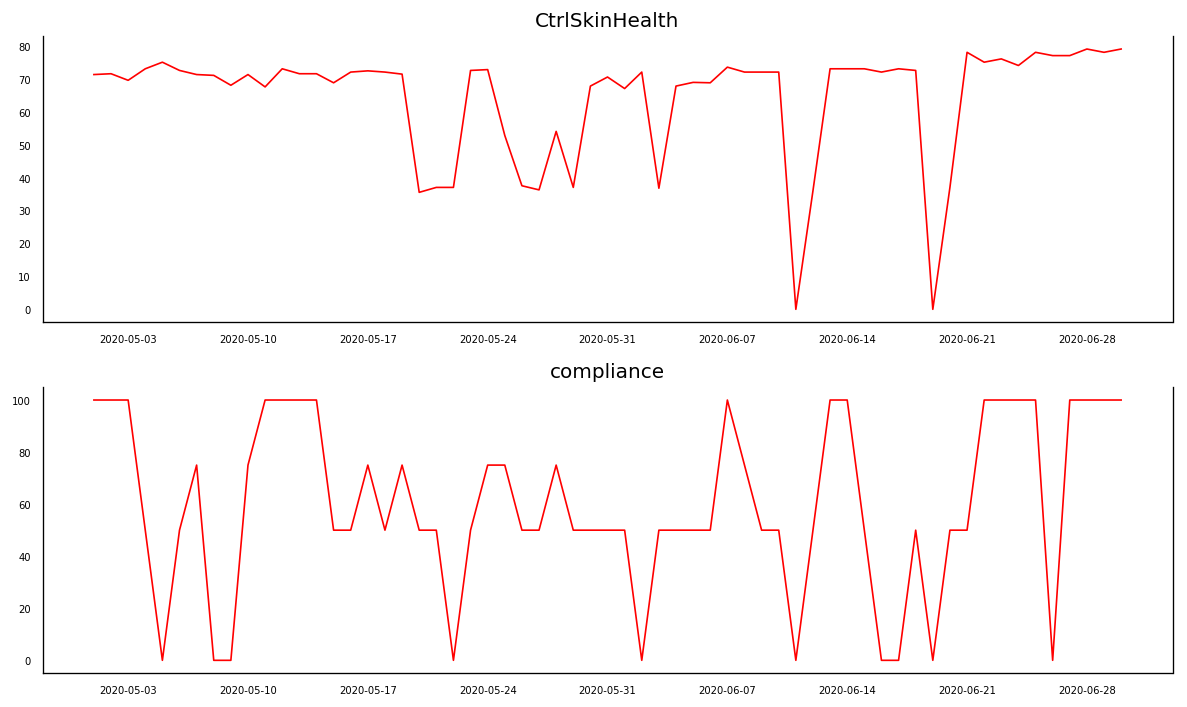

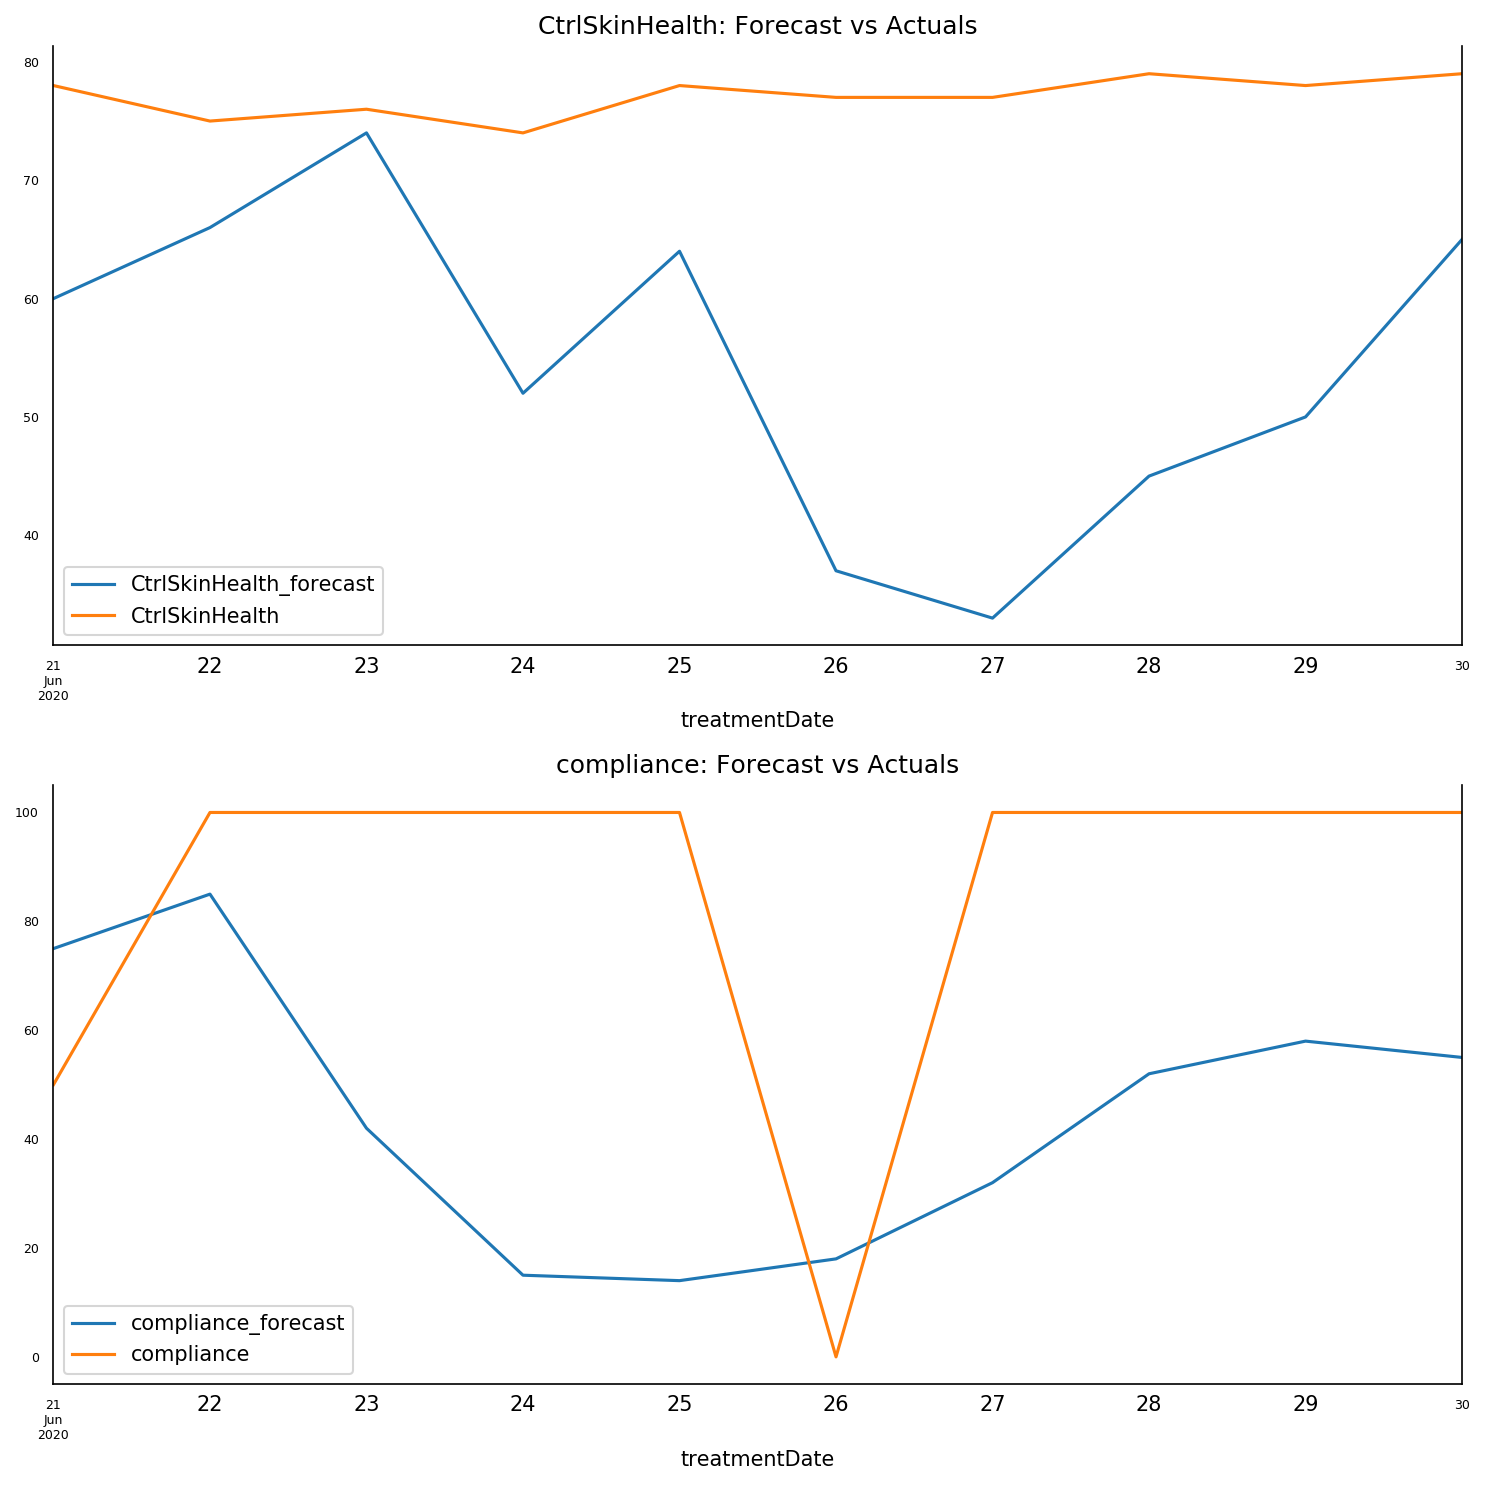

In [78]:
VARmod(client1)